# Cell Nuclei Counting
--------------

##### Summary:
1. Counts of every person are imported.
2. All EM counts are merged (for both EM_3 and EM_5).
3. Finding outliers of merged EM data by using nearest neighbors.
4. Manually selecting the cell nuclei which are not outliers for both EM_3 and EM_5: The true cell nuclei count.
5. Finding confusion matrix (tp, fp, fn, not tn) of every FM and PRED, using the true cell nuclei.

In [1]:
## Import libraries
import numpy as np
import prtools as pr
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2
import os
import datetime

## 1. Importing all counts
------

In [2]:
## Files names
dir_ = 'Files/'
name_dir = ['CellCounter_Pancreas_13479_5_EM.xml', 'CellCounter_Pancreas_13479_5_FM_hoechst.xml', 'CellCounter_Pancreas_13479_5_PRED_hoechst.xml',
            'CellCounter_Pancreas_134910_3_EM.xml', 'CellCounter_Pancreas_134910_3_FM_hoechst.xml', 'CellCounter_Pancreas_134910_3_PRED_hoechst.xml']

def getList(dir_):
    'Create list of all directories containing cell counter files'
    return [dir_+f for f in os.listdir(dir_) if os.path.isdir(os.path.join(dir_, f)) and not f.startswith('.') ]

def setList(sub_dir, name_dir):
    'Create list of all cell counter files'
    list_dir = []
    for i in range(len(sub_dir)):
        semi_list = []
        for j in range(len(name_dir)):
            semi_list.append(sub_dir[i] + '/' + name_dir[j])
        list_dir.append(semi_list)
    return list_dir

## Get list of all cell counter files
sub_dir = getList(dir_)
files = setList(sub_dir, name_dir)

## Find coordinates of all counts
data = []
for k in range(len(files)):
    'Acquire all cell counts and coordinates from files'
    semi_data = []
    for j in range(len(files[k])):
        tree = ET.parse(files[k][j])
        root = tree.getroot()
        
        semi_semi_data = []
        for i, marker in enumerate (root[1][1].findall('Marker')):
            semi_semi_data.append((int(marker.find('MarkerX').text), int(marker.find('MarkerY').text)))
        semi_data.append(semi_semi_data)
    data.append(semi_data)    

def getROI(FM_data, OTHER_data):
    'Crop EM/PRED to smaller FoV of FM'
    x_min, y_min = min(FM_data,key=lambda item:item[0])[0], min(FM_data,key=lambda item:item[1])[1]
    x_max, y_max = max(FM_data,key=lambda item:item[0])[0], max(FM_data,key=lambda item:item[1])[1]
    return [slide for slide in OTHER_data if x_min < slide[0] < x_max and y_min < slide[1] < y_max]

## Get percentages
percentages = []
for k in range(len(data)):
    'Find total number of cell nuclei counts per image and counter'
    amount = []
    for j in range(6): 
        amount.append(len(data[k][j]))

    PRED_EM_0 = amount[2]/amount[0]
    FM_PRED_0 = amount[1]/len(getROI(data[k][1],data[k][2]))
    FM_EM_0 = amount[1]/len(getROI(data[k][1],data[k][0]))
    PRED_EM_1 = amount[5]/amount[3]
    FM_PRED_1 = amount[4]/len(getROI(data[k][4],data[k][5]))
    FM_EM_1 = amount[4]/len(getROI(data[k][4],data[k][3]))
    percentages.append([PRED_EM_0, FM_PRED_0, FM_EM_0, PRED_EM_1, FM_PRED_1, FM_EM_1])

PRED_EM_0 = [i for i,j,k,l,m,n in percentages]     #PRED/EM
FM_PRED_0 = [j for i,j,k,l,m,n in percentages]     #FM/PRED
FM_EM_0 =  [k for i,j,k,l,m,n in percentages]      #FM/EM
PRED_EM_1 = [l for i,j,k,l,m,n in percentages]     #PRED/EM
FM_PRED_1 = [m for i,j,k,l,m,n in percentages]     #FM/PRED
FM_EM_1 = [n for i,j,k,l,m,n in percentages]       #FM/EM

print('If >1, then more recognized in prediction:')
print('PRED/EM = ', [np.mean(PRED_EM_0), np.mean(PRED_EM_1)])
print('STD = ',      [np.std(PRED_EM_0), np.std(PRED_EM_1)])
print('')
print('If >1, then more recognized in FM image than in prediction:')
print('FM/PRED = ', [np.mean(FM_PRED_0), np.mean(FM_PRED_1)])
print('STD = ', [np.std(FM_PRED_0), np.std(FM_PRED_1)])
print('')
print('If >1, then more recognized in FM image than in EM image:')
print('FM/EM = ', [np.mean(FM_EM_0), np.mean(FM_EM_1)])
print('STD = ',[np.std(FM_EM_0), np.std(FM_EM_1)])


If >1, then more recognized in prediction:
PRED/EM =  [1.0306435694106795, 1.0216154577010796]
STD =  [0.14613133120485844, 0.17702823830470593]

If >1, then more recognized in FM image than in prediction:
FM/PRED =  [0.7956127756357143, 0.8672528969861585]
STD =  [0.12847206926391824, 0.055130258867098644]

If >1, then more recognized in FM image than in EM image:
FM/EM =  [0.8795740930674483, 0.9395028782083955]
STD =  [0.1596475411831757, 0.11538708230601026]


## 2. Merging all EM_3 and EM_5 counts
------

In [3]:
img_name = 2  #1=EM_5, 2=EM_3
type_d = 0 # 0=EM, 1=FM, 2=PRED 
all_data = []
for p in range(len(data)):
    'Merge counts of all counters for a specific image'
    if img_name == 1:
        if type_d == 0:
            all_data += data[p][0]
        elif type_d == 1:
            all_data += data[p][1]
        else:
            all_data += data[p][2]
    if img_name == 2:
        if type_d == 0:
            all_data += data[p][3]
        elif type_d == 1:
            all_data += data[p][4]
        else:
            all_data += data[p][5]

## 3. Finding Outliers by using Nearest Neighbors
------

Select amount of nearest neighbours: n_neighbors. \
Eventually create histogram to find optimum of n_neigbors. \
Create figure in which outliers are shown in red. \
Figure is now created to large as tight_layout is not working perfect. \
Different approach is used: Just make figure with outliers in red. Use normal (blank) EM file to mark the non-outliers manually.

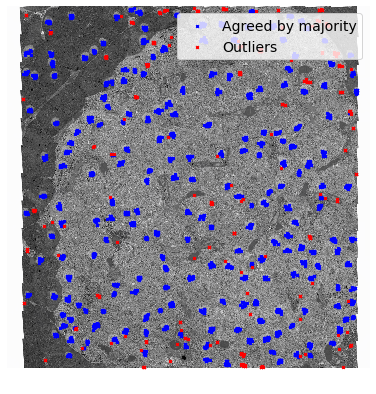

In [4]:
## Perform nearest neighbors on all data
X = all_data
n_neighbors = len(data)-5     # true cell nuclei if n_counters-x agree if its a nuclei (75%)
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute').fit(X)
distances, indices = nbrs.kneighbors(X)

## Find average distance of every nuclei to its nearest neighbors
tot_dist = np.sum(distances, axis = 1) / (n_neighbors)

## Find outliers which have a too large average distance
dist_constrain = 10     # avg distance constraint (~FWHM of standard gaussian on cell nuclei)
out_indices = np.where(tot_dist > dist_constrain)
newArr = [all_data[i] for i in out_indices[0]]    #outliers  
in_indices = np.where(tot_dist <= dist_constrain)
X_2 = [all_data[i] for i in in_indices[0]]    #non outliers

## Create figure
fig_size = 7
fig = plt.figure(figsize=(fig_size,fig_size))
filename = 'Figures/Pancreas_134910_3_EM.png'
em_img = cv2.imread(filename)
plt.imshow(em_img[:,:])
s = 7
a = plt.scatter(*zip(*X_2), color='b',marker='x',s=s,linewidths=2)
b = plt.scatter(*zip(*newArr),color='r',marker='x',s=s,linewidths=2)
plt.axis('off')
plt.legend(('Agreed by majority', 'Outliers'), scatterpoints=1, fontsize=14, loc='upper right')  
plt.show()
fig.savefig('Eoutlier.png', bbox_inches='tight')

## 4. Manually selecting non-outliers in EM_5 and EM_3 to find 'true' cell nuclei count
------

Import outlier files. \
Find largest half cell nuclei length for EM_5 and EM_3.

In [5]:
## Import outlier files and data
name_dir = ['Pancreas_13479_5_EM_Mean.xml', 'Pancreas_134910_3_EM_Mean.xml', 
            'CellCounter_EM_1_nucleus.xml', 'CellCounter_EM_2_nucleus.xml']
sub_dir = ['MeanCellNuclei']
files = setList(sub_dir, name_dir)

data_mean = []
for k in range(len(files)):
    'Acquire all cell counts and coordinates from files'
    semi_data = []
    for j in range(len(files[k])):
        tree = ET.parse(files[k][j])
        root = tree.getroot()
        semi_semi_data = []
        for i, marker in enumerate (root[1][1].findall('Marker')):
            semi_semi_data.append((int(marker.find('MarkerX').text), int(marker.find('MarkerY').text)))
        semi_data.append(semi_semi_data)
    data_mean.append(semi_data)    

## Finding largest half cell nuclei length in pixels
EM_1_mean = data_mean[0][0]
EM_2_mean = data_mean[0][1]
EM_1_dist = data_mean[0][2]
EM_2_dist = data_mean[0][3]
EM_1_dist = 0.5*np.sqrt((EM_1_dist[0][0]-EM_1_dist[1][0])**2 + (EM_1_dist[0][1]-EM_1_dist[1][1])**2)
EM_2_dist = 0.5*np.sqrt((EM_2_dist[0][0]-EM_2_dist[1][0])**2 + (EM_2_dist[0][1]-EM_2_dist[1][1])**2)
print('Largest half cell nuclei length EM_5:',int(EM_1_dist))
print('Largest half cell nuclei length EM_3:',int(EM_2_dist))

Largest half cell nuclei length EM_5: 13
Largest half cell nuclei length EM_3: 13


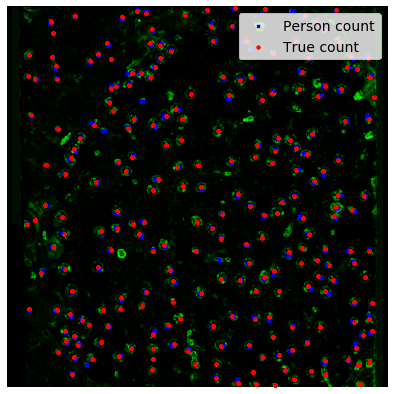

In [6]:
## Figure to visualize differences between 'true' cell nuclei count and count of one particular person.
person = 18
img_name = 2

filename = 'Figures/Pancreas_13479_5_FM.png'
em_img = cv2.imread(filename)

fig_size = 7
s = 8
fig = plt.figure(figsize=(fig_size,fig_size))

for p in range(len(data)):
    if img_name == 1:
        a = plt.scatter(*zip(*data[person][0]), color='b',marker='x',s=s,linewidths=2)
        b = plt.scatter(*zip(*EM_1_mean),s=s+3, color='g')
        filename = 'Figures/Pancreas_13479_5_EM.png'
    if img_name == 2:
        a = plt.scatter(*zip(*data[person][3]), color='b',marker='x',s=s,linewidths=2)
        b = plt.scatter(*zip(*EM_2_mean),s=s+3, color='r')
        filename = 'Figures/Pancreas_134910_3_PRED_hoechst.png'

em_img = cv2.imread(filename)
plt.imshow(em_img[:,:])    
plt.legend(('Person count', 'True count'), scatterpoints=1, fontsize=14, loc='upper right')  
plt.axis('off')
plt.show()
fig.savefig('truecount.png', bbox_inches='tight')

## 5. Finding Confusion Matrix
------

Of confusion matrix only tp, fp and fn can be found, not tn. \
With tp and fp, precision can be found. Precision: How many selected items are relevant. \
With tp and fn, recall can be found. Recall: How many relevant items are selected.

In [7]:
def dist(nuclei, mean):
    'Finding distance between two points in 2D space'
    return np.sqrt((nuclei[0]-mean[0])**2+(nuclei[1]-mean[1])**2)

## Finding Precision and Recall for all images (EM, FM and PRED)
for k in range(6):
    ## Selecting image to find confusion matrix for
    type_d = k # 0=EM_5,  1=FM_5, 2=PRED_5, 3=EM_3, 4=FM_3, 5=PRED_3
    if type_d == 0 or type_d == 1 or type_d == 2:
        EM_mean_nuclei_0 = EM_1_mean
        if type_d == 0:
            print('Finding values for EM_1')
        elif type_d == 1:
            print('Finding values for FM_1')
        elif type_d == 2:
            print('Finding values for PRED_1')
    else:
        EM_mean_nuclei_0 = EM_2_mean
        if type_d == 3:
            print('Finding values for EM_2')
        elif type_d == 4:
            print('Finding values for FM_2')
        elif type_d == 5:
            print('Finding values for PRED_2')

    ## Determining confusion matrix       
    conf_matrix = []
    for i in range(len(data)):
        person = i
        EM_nuclei = data[person][type_d]
        EM_mean_nuclei = EM_mean_nuclei_0
        if type_d == 1 or type_d == 4:
            EM_mean_nuclei = getROI(data[person][type_d],EM_mean_nuclei_0)
        if type_d == 2 or type_d ==5:
            EM_mean_nuclei = getROI(data[person][type_d-1],EM_mean_nuclei_0)
            EM_nuclei = getROI(data[person][type_d-1],data[person][type_d])
        if type_d == 0 or type_d == 3:
            EM_mean_nuclei = getROI(data[person][type_d+1],EM_mean_nuclei_0)
            EM_nuclei = getROI(data[person][type_d+1],data[person][type_d])

        ## find tp and fp
        nuc_mask = np.zeros((1, len(EM_nuclei)))
        mask = np.zeros((1, len(EM_nuclei)))
        for i in range(len(EM_mean_nuclei)): 
            for j in range(len(EM_nuclei)):
                nuc_mask[0,j] = dist(EM_nuclei[j], EM_mean_nuclei[i]) < 13
            mask += nuc_mask
        mask = mask>0
        tp = np.sum(mask)
        fp = len(EM_nuclei)-np.sum(mask)

        ## find fn (tp should be same as tp above, can be more. But above is more accurate)
        tru_mask = np.zeros((1, len(EM_mean_nuclei)))
        mask = np.zeros((1, len(EM_mean_nuclei)))
        for i in range(len(EM_nuclei)): 
            for j in range(len(EM_mean_nuclei)):
                tru_mask[0,j] = dist(EM_nuclei[i], EM_mean_nuclei[j]) < 13
            mask += tru_mask
        mask = mask>0
        fn = len(EM_mean_nuclei)-np.sum(mask)
        
        conf_matrix.append((tp,fp,fn))

    precision = []
    recall = []
    for i in range(len(conf_matrix)):
        precision.append(conf_matrix[i][0]/(conf_matrix[i][0]+conf_matrix[i][1]))
        recall.append(conf_matrix[i][0]/(conf_matrix[i][0]+conf_matrix[i][2]))

    # EM5, FM5, PRED5, EM3, FM3, PRED3 
    print('Precision (mean and std):', np.mean(precision), np.std(precision))
    print('Recall (mean and std):', np.mean(recall), np.std(recall))



Finding values for EM_1
Precision (mean and std): 0.9388379337595548 0.04603979677111838
Recall (mean and std): 0.8508844935396765 0.06821099504448194
Finding values for FM_1
Precision (mean and std): 0.6558393430271352 0.10519476626000179
Recall (mean and std): 0.5113757216580254 0.06868244152641961
Finding values for PRED_1
Precision (mean and std): 0.790814522691142 0.11537047665771352
Recall (mean and std): 0.7809056691619981 0.07420010042084624
Finding values for EM_2
Precision (mean and std): 0.9612727569701874 0.021005793447631135
Recall (mean and std): 0.8842522289360568 0.06384401118249837
Finding values for FM_2
Precision (mean and std): 0.8309970126682754 0.08637559530678561
Recall (mean and std): 0.7097530422243443 0.07011801448636563
Finding values for PRED_2
Precision (mean and std): 0.8713197752298047 0.06995173391200699
Recall (mean and std): 0.860299052393738 0.05859166420841226
